# Twitter Sentiment Analysis: EDA 
### Importing Libraries - Load Databases

In [119]:
import pandas as pd
import numpy as np
import nltk
from nltk.collocations import *
from nltk import FreqDist
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer
from nltk.stem import PorterStemmer
from collections import Counter
from collections import defaultdict
import string
import itertools as it
import emoji
import re
import spacy
import fileinput
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import confusion_matrix,roc_auc_score,classification_report

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB

%matplotlib inline

In [120]:
twitter_training = pd.read_csv('twitter_training.csv', sep=',', names=['Tweet ID','Entity','Sentiment','Tweet_content'])
twitter_validation = pd.read_csv('twitter_validation.csv', sep=',', names=['Tweet ID','Entity','Sentiment','Tweet_content'])

In [121]:
twitter_training["Tweet ID"] = range(1, len(twitter_training) + 1)
twitter_validation["Tweet ID"] = range(1, len(twitter_validation) + 1)

## - Exploration of each dataset

In [122]:
twitter_training.head(3)

,Tweet ID,Entity,Sentiment,Tweet_content
0,1,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2,Borderlands,Positive,I am coming to the borders and I will kill you...
2,3,Borderlands,Positive,im getting on borderlands and i will kill you ...


In [123]:
twitter_training.tail(3)

,Tweet ID,Entity,Sentiment,Tweet_content
74679,74680,Nvidia,Positive,Just realized the windows partition of my Mac ...
74680,74681,Nvidia,Positive,Just realized between the windows partition of...
74681,74682,Nvidia,Positive,Just like the windows partition of my Mac is l...


In [124]:
twitter_validation.head(3)

,Tweet ID,Entity,Sentiment,Tweet_content
0,1,Facebook,Irrelevant,I mentioned on Facebook that I was struggling ...
1,2,Amazon,Neutral,BBC News - Amazon boss Jeff Bezos rejects clai...
2,3,Microsoft,Negative,@Microsoft Why do I pay for WORD when it funct...


In [125]:
twitter_validation.tail(3)

,Tweet ID,Entity,Sentiment,Tweet_content
997,998,Borderlands,Positive,Today sucked so it’s time to drink wine n play...
998,999,Microsoft,Positive,Bought a fraction of Microsoft today. Small wins.
999,1000,johnson&johnson,Neutral,Johnson & Johnson to stop selling talc baby po...


In [126]:
# remove dupicate and nan values
twitter_training.dropna(inplace=True)
twitter_training.drop_duplicates(inplace=True)

In [127]:
twitter_training.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 73996 entries, 0 to 74681
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       73996 non-null  int32 
 1   Entity         73996 non-null  object
 2   Sentiment      73996 non-null  object
 3   Tweet_content  73996 non-null  object
dtypes: int32(1), object(3)
memory usage: 2.5+ MB


In [128]:
twitter_validation.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet ID       1000 non-null   int32 
 1   Entity         1000 non-null   object
 2   Sentiment      1000 non-null   object
 3   Tweet_content  1000 non-null   object
dtypes: int32(1), object(3)
memory usage: 27.5+ KB


## - Finding Emojis in Dataframe

In [129]:
# Find emojis in whole dataframe training set

# Dictionary storing emoji counts 
emoji_training_count = defaultdict(int)
for i in twitter_training['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]', i):
        emoji_training_count[emoji] += 1
    
# Find emojis in whole dataframe validation set

emoji_validation_count = defaultdict(int)
for i in twitter_validation['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]|[\U0001F600-\U0001F64F]|[\U0001F300-\U0001F5FF]|[\U0001F680-\U0001F6FF]|[\U0001F1E0-\U0001F1FF]|[\U00002702-\U000027B0]|[\U000024C2-\U0001F251]', i):
        emoji_validation_count[emoji] += 1
    
print(emoji_training_count)
print(emoji_validation_count)
#- is there another way to find these emojis... what if we didn't find them all?

defaultdict(<class 'int'>, {'’': 9342, '‼': 27, '–': 213, '⃣': 55, '…': 3632, '•': 322, '′': 53, '“': 746, '”': 724, '‘': 231, '\u200d': 243, '—': 146, '″': 20, '→': 60, '₹': 5, '€': 30, '−': 7, '†': 12, '™': 34, '‡': 2, '🙂': 4, '⌚': 4, '‖': 8, '←': 1, '�': 9, '\u2060': 14, '„': 8, '）': 1, 'ℐ': 2, 'ℓ': 2, '√': 5, '■': 1, '\u2066': 37, '\u2069': 37, '，': 1, '。': 3, '≧': 2, '∇': 2, '≦': 2, '↑': 1, '\u200b': 9, '⁴': 1, '：': 2, '※': 2, '・': 1, '⏬': 2, '⇒': 3, '⇐': 1, '●': 1, '★': 1, '（': 1, '\u2063': 10, '⁄': 2, '₂': 2, '‚': 1, '⏳': 2})
defaultdict(<class 'int'>, {'’': 213, '‘': 9, '…': 140, '🙄': 1, '😆': 3, '🔥': 19, '😭': 18, '😍': 15, '😀': 1, '😳': 1, '👌': 1, '👏': 1, '😅': 5, '💛': 2, '☺': 3, '️': 41, '💙': 2, '🙌': 2, '“': 14, '”': 13, '💪': 5, '🏾': 6, '👍': 15, '🏆': 1, '😠': 1, '⚡': 1, '👀': 6, '🙏': 2, '❤': 15, '😒': 4, '🇳': 1, '🇬': 1, '💚': 7, '😩': 3, '👊': 3, '♥': 4, '😔': 3, '✊': 2, '–': 2, '\u200d': 9, '♂': 8, '😊': 2, '\u2066': 2, '\u2069': 2, '🌄': 1, '👇': 1, '💯': 2, '😡': 1, '☠': 6, '—': 5, '→': 2

In [130]:
#remove urls & special characters
def remove_urls(text):
    """Berilgan matndan URL larini o'chiradi"""
    url_pattern = re.compile(r'https?://\S+|www\.\S+')
    return url_pattern.sub(r'', text)

def remove_emojis(text):
    """Berilgan matndan emojilarni o'chiradi"""
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emojilar
                               u"\U0001F300-\U0001F5FF"  # simvollar va diagrammalar
                               u"\U0001F680-\U0001F6FF"  # transport va turli joylar
                               u"\U0001F1E0-\U0001F1FF"  # davlat bayroqlari
                               u"\U00002702-\U000027B0"  # dingbats
                               u"\U000024C2-\U0001F251"  # alamatchilik belgilari
                               u"\U0001f300-\U0001f650"  
                               u"\u2000-\u3000" 
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)
#def remove_and,or,a,the...

In [131]:
twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_training['Tweet_content'] = twitter_training['Tweet_content'].apply(lambda x: remove_urls(x))

twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_emojis(x))
twitter_validation['Tweet_content'] = twitter_validation['Tweet_content'].apply(lambda x: remove_urls(x))

In [132]:
# Testing we indeed removed the emojis:

emoji_count_t = defaultdict(int)
for i in twitter_training['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]', i):
        emoji_count_t[emoji] += 1

emoji_count_v = defaultdict(int)
for i in twitter_validation['Tweet_content']:
    for emoji in re.findall(u'[\U0001f300-\U0001f650]|[\u2000-\u3000]', i):
        emoji_count_v[emoji] += 1

print(emoji_count_t)
print(emoji_count_v)

defaultdict(<class 'int'>, {})
defaultdict(<class 'int'>, {})


In [133]:
for col in twitter_training:
    twitter_training.loc[twitter_training['Sentiment'] == 'Irrelevant', 'Sentiment']='Neutral'

for col in twitter_validation:
    twitter_validation.loc[twitter_validation['Sentiment'] == 'Irrelevant', 'Sentiment']='Neutral'
print(set(twitter_validation['Sentiment']))

{'Positive', 'Negative', 'Neutral'}


In [134]:
#Count information per category

twitter_training['text_lens']=twitter_training['Tweet_content'].apply(lambda x: len(x))
twitter_validation['text_lens']=twitter_validation['Tweet_content'].apply(lambda x: len(x))

data1=twitter_training.groupby(by=["Entity","Sentiment"]).count().reset_index()
data1.head()

,Entity,Sentiment,Tweet ID,Tweet_content,text_lens
0,Amazon,Negative,575,575,575
1,Amazon,Neutral,1393,1393,1393
2,Amazon,Positive,308,308,308
3,ApexLegends,Negative,591,591,591
4,ApexLegends,Neutral,1128,1128,1128


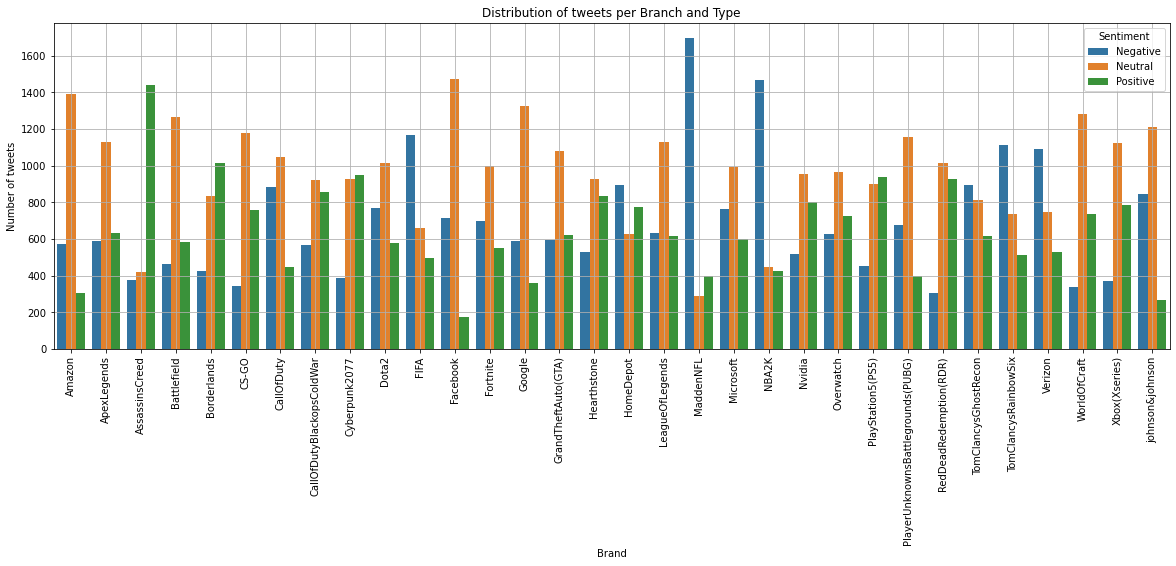

In [135]:
#Figure of comparison per branch
plt.figure(figsize=(20,6))
sns.barplot(data=data1,x="Entity",y="Tweet ID",hue='Sentiment')
plt.xticks(rotation=90)
plt.xlabel("Brand")
plt.ylabel("Number of tweets")
plt.grid()
plt.title("Distribution of tweets per Branch and Type")
plt.show()

## - Data Cleaning / Preprocessing for Medeling

#### 1.- Entity Recognition

In [136]:
Entities_training = list(set(twitter_training['Entity']))
print(Entities_training)
#Entities_validation = list(set(twitter_validation['Entity']))
#print(Entities_validation)

['Dota2', 'Cyberpunk2077', 'CS-GO', 'AssassinsCreed', 'Hearthstone', 'Microsoft', 'Facebook', 'CallOfDuty', 'Google', 'MaddenNFL', 'FIFA', 'RedDeadRedemption(RDR)', 'PlayStation5(PS5)', 'TomClancysGhostRecon', 'Borderlands', 'Overwatch', 'Amazon', 'NBA2K', 'LeagueOfLegends', 'ApexLegends', 'Verizon', 'TomClancysRainbowSix', 'GrandTheftAuto(GTA)', 'Xbox(Xseries)', 'Fortnite', 'Nvidia', 'WorldOfCraft', 'PlayerUnknownsBattlegrounds(PUBG)', 'CallOfDutyBlackopsColdWar', 'Battlefield', 'HomeDepot', 'johnson&johnson']


In [137]:
#Creating our entity dictionary:
entity_dict = { 
                "RedDeadRedemption" : ['reddeadredemption', 'red dead redemption', 'red dead', 'rdr'], 
                "Microsoft": ['microsoft'],
                "Xbox":['xboxseriesx', 'xboxseriess', 'xboxone', 'xbox series x', 'xbox series s', 'xbox one', 'xseries', 'xbox'], 
                "AssassinsCreed": ['assassinscreed', 'assassins creed valhalla', 'assassins creed odyssey', 'assassins creed origins', 'assassins creed syndicate', 'assassins creed'], 
                "CallOfDutyBlackopsColdWar": ['callofdutyblackopscoldwar', 'codblackopscoldwar', 'blackopscoldwar', 'callofdutyblackops', 'codblackops', 'blackops', 'call of duty black ops cold war', 'cod black ops cold war', 'call of duty black ops', 'cod black ops', 'black ops cold war', 'black ops', 'cold war'],
                "FIFA": ['fifa22', 'fifa21', 'fifa20', 'fifa19', 'fifa18', 'fifa 22', 'fifa 21', 'fifa 20', 'fifa 19', 'fifa'],
                "TomClancysGhostRecon": ['tomclancysghostrecon', 'tomclancys', 'ghostrecon', 'tom clancys ghost recon', 'tom clancys', 'ghost recon'],
                "Google": ['google'],
                "PlayStation": ['playstation', 'storeplaystation','playstation store', 'ps5', 'ps4', 'ps3', 'PS'],
                "Facebook": ['facebook'],
                "GrandTheftAuto": ['grandtheftautov', 'grandtheftauto5', 'grandtheftauto', 'grand theft auto v', 'grand theft auto 5', 'grand theft auto', 'gtav', 'gta v' , 'gta'],
                "PlayerUnknownsBattlegrounds": ['playerunknownsbattlegrounds', 'player unknowns battlegrounds', 'pubg'],
                "Hearthstone": ['hearthstone'],
                "MaddenNFL": ['maddengame', 'madden'],
                "CallOfDuty": ['modernwarfare', 'callofduty', 'modern warfare' ,'call of duty', 'cod'],
                "Fortnite": ['fortnitegame', 'fortnite'],
                "Verizon": ['verizon'],
                "Nvidia": ['nvidia'],
                "Amazon": ['amazonplay', 'amazon', 'amazon play'],
                "WorldOfCraft": ['worldofwarcraft', 'world of warcraft', 'wow'],
                "ApexLegends": ['apexlegends', 'apex legends', 'apex'],
                "CS-GO": ['counterstrike', 'counter strike', 'csgo', 'cs go'],
                "johnson&johnson": ['johnson&johnson', 'johnson & johnson', 'johnsonjohnson'],
                "HomeDepot": ['homedepot', 'home depot'],
                "NBA2K": ['nba'],
                "Overwatch": ['overwatch'],
                "LeagueOfLegends": ['leagueoflegends', 'league of legends', 'lol'],
                "Borderlands": ['borderlands1', 'borderlands2', 'borderlands3', 'borderlans 1', 'borerlands 2', 'borderlands 3', 'borderlands'],
                "TomClancysRainbowSix": ['rainbowsixsiege', 'rainbowsix', 'rainbow six siege', 'rainbow six', 'rainbow'],
                "Dota": ['dota'],
                "Battlefield": ['battlefieldv', 'battlefield5', 'battlefield1', 'battlefield v', 'battlefield 5', 'battlefield 1', 'battlefield'],
                "Cyberpunk2077": ['cyberpunkgame', 'cyberpunk2077', 'cyberpunk'],
                "NintendoSwitch": ['nintendoswitch', 'nintendo switch', 'nintendo'],
                "Windows": ['windows', 'window']
              }
#Note: What about diferent games of the same saga like: COD black ops/modern warfare/cold war... what should we do?  (Check: )

In [138]:
comment = "on Borderlands 1 I will murder all on Xbox the console of microsoft, is like RDR or Assassin's-creed..."
#comment = "I love assassinscreedvalhalla"
#comment = twitter_training["Tweet_content"][292]

comment = re.sub(r"[^a-zA-Z0-9 ]", "", comment) #Remove apostrophes, comas, ... 
print(comment)

comment = ' '.join([word for word in comment.split()]) #Remove whitespaces
print(comment.lower())

on Borderlands 1 I will murder all on Xbox the console of microsoft is like RDR or Assassinscreed
on borderlands 1 i will murder all on xbox the console of microsoft is like rdr or assassinscreed


In [139]:
#Removing entities function

def remove_entities_list(text):
    text = re.sub(r"[^a-zA-Z0-9 ]", "", text)
    text = ' '.join([word for word in text.split()])
    text = text.lower()
    for entity_names in entity_dict:
        for game_names in entity_dict[entity_names]:
            if game_names.lower() in text:
                #print(game_names)
                text = text.replace(game_names, '')
                #print(text)
    text = ' '.join([word for word in text.split()])
    return text

print(remove_entities_list(comment))

on 1 i will murder all on the console of is like or


In [140]:
#Before removing entities
twitter_training["Tweet_content"][24432]

" . I played this interesting Quiz on Amazon-Play games at Amazon FunZone . It's very easy to play try your luck for exciting rewards. Please download the Amazon app from Google Play Store amazon.in/game/share/gL9. I am eligible for win prize....."

In [141]:
#After removing entities
print(remove_entities_list(twitter_training["Tweet_content"][24432]))

i played this interesting quiz on games at funzone its very easy to play try your luck for exciting rewards please download the app from play store ingamesharegl9 i am eligible for win prize


In [142]:
#Entities Removed from Dataframes
twitter_training['Tweet_content'] = [remove_entities_list(word) for word in twitter_training['Tweet_content']]
twitter_validation['Tweet_content'] = [remove_entities_list(word) for word in twitter_validation['Tweet_content']]
print(twitter_validation['Tweet_content'])
print(twitter_training['Tweet_content'])

0      i mentioned on that i was struggling for motiv...
1      bbc news boss jeff bezos rejects claims compan...
2      why do i pay for word when it functions so poo...
3      matchmaking is so full of closet hacking its a...
4      now the president is slapping americans in the...
                             ...                        
995    toronto is the arts and culture capital of can...
996    this is actually a good move tot bring more vi...
997    today sucked so its time to drink wine n play ...
998                bought a fraction of today small wins
999    johnson johnson to stop selling talc baby powd...
Name: Tweet_content, Length: 1000, dtype: object
0                  im getting on and i will murder you all
1        i am coming to the borders and i will kill you...
2                    im getting on and i will kill you all
3                   im coming on and i will murder you all
4             im getting on 2 and i will murder you me all
                             

#### 2.-  Tokenization/Bag of words

In [ ]:
token_pattern = r"(?u)\b\w\w+\b" #default token pattern
tokenizer = RegexpTokenizer(token_pattern)

In [ ]:
tokens_training = twitter_training["Tweet_content"].apply(tokenizer.tokenize)
tokens_training

In [143]:
#twitter_training['Tweet_content'] = [word.lower() for word in twitter_training['Tweet_content']]
#twitter_training['Tweet_content']

#Tokenize every entry in the data set, list of tokens
tokenized_twitter_training = [word_tokenize(word) for word in twitter_training['Tweet_content']]
tokenized_twitter_validation = [word_tokenize(word) for word in twitter_validation['Tweet_content']]
twitter_training['Tokenized Tweets'] = [word_tokenize(word) for word in twitter_training['Tweet_content']]
twitter_validation['Tokenized Tweets'] = [word_tokenize(word) for word in twitter_validation['Tweet_content']]

#Transforming into a single list (This only functions to see how are the tokens?)
tokenized_twitter_training_list = list(map(str, it.chain.from_iterable(tokenized_twitter_training)))
tokenized_twitter_validation_list = list(map(str, it.chain.from_iterable(tokenized_twitter_validation)))
#tokenized_twitter_training[:10]

twitter_training.tail(10)

,Tweet ID,Entity,Sentiment,Tweet_content,text_lens,Tokenized Tweets
74672,74673,Nvidia,Positive,let no elite go unnoticed highlights automatic...,112,"[let, no, elite, go, unnoticed, highlights, au..."
74673,74674,Nvidia,Positive,let no elim go unnoticed highlights automatica...,118,"[let, no, elim, go, unnoticed, highlights, aut..."
74674,74675,Nvidia,Positive,let a no information elim that go unnoticed hi...,164,"[let, a, no, information, elim, that, go, unno..."
74675,74676,Nvidia,Positive,unk my elim be no highlights pictures reveals ...,119,"[unk, my, elim, be, no, highlights, pictures, ..."
74676,74677,Nvidia,Positive,just realized the partition of my mac is like ...,124,"[just, realized, the, partition, of, my, mac, ..."
74677,74678,Nvidia,Positive,just realized that the partition of my mac is ...,128,"[just, realized, that, the, partition, of, my,..."
74678,74679,Nvidia,Positive,just realized that my mac partition is 6 years...,117,"[just, realized, that, my, mac, partition, is,..."
74679,74680,Nvidia,Positive,just realized the partition of my mac is now 6...,124,"[just, realized, the, partition, of, my, mac, ..."
74680,74681,Nvidia,Positive,just realized between the partition of my mac ...,158,"[just, realized, between, the, partition, of, ..."
74681,74682,Nvidia,Positive,just like the partition of my mac is like 6 ye...,118,"[just, like, the, partition, of, my, mac, is, ..."


In [144]:
# Removing stopwords, punctuation and numbers
#stopwords_list += ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
stopwords_list = stopwords.words('english')
stopwords_list += list(string.punctuation)
stopwords_list += ['....','...', '..', '’', "''", '``', '-', "'", "([a-zA-Z]+(?:'[a-z]+)?)"]
tokenized_twitter_training_stopped = [word for word in tokenized_twitter_training_list if word not in stopwords_list]
tokenized_twitter_validation_stopped = [word for word in tokenized_twitter_validation_list if word not in stopwords_list]

twitter_training['Tokenized Tweets'] = [word for word in twitter_training['Tokenized Tweets'] if word not in stopwords_list]
twitter_validation['Tokenized Tweets'] = [word for word in twitter_validation['Tokenized Tweets'] if word not in stopwords_list]
twitter_training['Tokenized Tweets']

0        [im, getting, on, and, i, will, murder, you, all]
1        [i, am, coming, to, the, borders, and, i, will...
2          [im, getting, on, and, i, will, kill, you, all]
3         [im, coming, on, and, i, will, murder, you, all]
4        [im, getting, on, 2, and, i, will, murder, you...
                               ...                        
74677    [just, realized, that, the, partition, of, my,...
74678    [just, realized, that, my, mac, partition, is,...
74679    [just, realized, the, partition, of, my, mac, ...
74680    [just, realized, between, the, partition, of, ...
74681    [just, like, the, partition, of, my, mac, is, ...
Name: Tokenized Tweets, Length: 73996, dtype: object

In [145]:
def listToString(s):
    str1 = " "
    return (str1.join(s))
     
twitter_training['Tokenized Tweets'] = [listToString(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [listToString(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets']

0                  im getting on and i will murder you all
1        i am coming to the borders and i will kill you...
2                    im getting on and i will kill you all
3                   im coming on and i will murder you all
4             im getting on 2 and i will murder you me all
                               ...                        
74677    just realized that the partition of my mac is ...
74678    just realized that my mac partition is 6 years...
74679    just realized the partition of my mac is now 6...
74680    just realized between the partition of my mac ...
74681    just like the partition of my mac is like 6 ye...
Name: Tokenized Tweets, Length: 73996, dtype: object

In [ ]:
# Frequency Distribution to see the number of times each word is used in each entry.
tokenized_twitter_training_freqdist = FreqDist(tokenized_twitter_training_stopped)
tokenized_twitter_validation_freqdist = FreqDist(tokenized_twitter_validation_stopped)
tokenized_twitter_training_freqdist.most_common(10)

In [ ]:
bigram_measures = nltk.collocations.BigramAssocMeasures()
tokenized_twitter_training_stopped_finder = BigramCollocationFinder.from_words(tokenized_twitter_training_stopped)
tokenized_twitter_training_stopped_scored = tokenized_twitter_training_stopped_finder.score_ngrams(bigram_measures.raw_freq)
# Display the first 10 elements of macbeth_scored
tokenized_twitter_training_stopped_scored[:10]

In [ ]:
trigram_measures = nltk.collocations.BigramAssocMeasures()
tokenized_twitter_training_stopped_finder = TrigramCollocationFinder.from_words(tokenized_twitter_training_stopped)
tokenized_twitter_training_stopped_scored = tokenized_twitter_training_stopped_finder.score_ngrams(trigram_measures.raw_freq)
# Display the first 10 elements of macbeth_scored
tokenized_twitter_training_stopped_scored[:10]

#### 3.- Stemming & Lemmatization

In [111]:
from nltk.stem.wordnet import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

twitter_training['Tokenized Tweets'] = [lemmatizer.lemmatize(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [lemmatizer.lemmatize(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets']
#tokenized_twitter_training_lemmatized = [lemmatizer.lemmatize(word) for word in twitter_training['Tokenized Tweets']]
#tokenized_twitter_validation_lemmatized = [lemmatizer.lemmatize(word) for word in twitter_validation['Tokenized Tweets']]
#tokenized_twitter_training_lemmatized[:10]

#lemmatizer.lemmatize('drank')

0                  im getting on and i will murder you all
1        i am coming to the borders and i will kill you...
2                    im getting on and i will kill you all
3                   im coming on and i will murder you all
4             im getting on 2 and i will murder you me all
                               ...                        
74677    just realized that the partition of my mac is ...
74678    just realized that my mac partition is 6 years...
74679    just realized the partition of my mac is now 6...
74680    just realized between the partition of my mac ...
74681    just like the partition of my mac is like 6 ye...
Name: Tokenized Tweets, Length: 73996, dtype: object

In [112]:
ps = PorterStemmer()

twitter_training['Tokenized Tweets'] = [ps.stem(word) for word in twitter_training['Tokenized Tweets']]
twitter_validation['Tokenized Tweets'] = [ps.stem(word) for word in twitter_validation['Tokenized Tweets']]
twitter_training['Tokenized Tweets']
#tokenized_twitter_training_stemmed = [ps.stem(word) for word in twitter_training['Tokenized Tweets']]
#tokenized_twitter_validation_stemmed = [ps.stem(word) for word in twitter_validation['Tokenized Tweets']]
#tokenized_twitter_training_stemmed[:10]

#words = ["play", "playing", "played", "player"]

#for w in words:
 #   print(w, " : ", ps.stem(w))

0                   im getting on and i will murder you al
1        i am coming to the borders and i will kill you al
2                     im getting on and i will kill you al
3                    im coming on and i will murder you al
4              im getting on 2 and i will murder you me al
                               ...                        
74677    just realized that the partition of my mac is ...
74678    just realized that my mac partition is 6 years...
74679    just realized the partition of my mac is now 6...
74680    just realized between the partition of my mac ...
74681    just like the partition of my mac is like 6 ye...
Name: Tokenized Tweets, Length: 73996, dtype: object

In [ ]:
len(tokenized_twitter_training_freqdist)

#### - Train/Test Splits

In [146]:
from sklearn.model_selection import train_test_split
X_train ,X_test , y_train, y_test = train_test_split(twitter_training[['Tokenized Tweets']], twitter_training[['Sentiment']], test_size=0.2, random_state=42)

In [147]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer= TfidfVectorizer()

X_train_vect= vectorizer.fit_transform(X_train['Tokenized Tweets'])
X_test_vect= vectorizer.transform(X_test['Tokenized Tweets'])

y_train=y_train['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})
y_test=y_test['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})

In [148]:
validation_X = vectorizer.transform(twitter_validation['Tokenized Tweets'])
validation_y = twitter_validation['Sentiment'].map({"Positive":0,"Negative":1,"Neutral":2})

#### MultinomialNB

In [149]:
#NO Lemmatization and Stemming
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.66      0.74      4119
           1       0.79      0.79      0.79      4380
           2       0.75      0.87      0.80      6301

    accuracy                           0.79     14800
   macro avg       0.80      0.77      0.78     14800
weighted avg       0.79      0.79      0.78     14800



In [55]:
#Using Lemmatization
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.66      0.74      4119
           1       0.79      0.79      0.79      4380
           2       0.75      0.87      0.80      6301

    accuracy                           0.79     14800
   macro avg       0.80      0.77      0.78     14800
weighted avg       0.79      0.79      0.78     14800



In [91]:
#Using Stemming
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      4119
           1       0.80      0.79      0.79      4380
           2       0.75      0.87      0.81      6301

    accuracy                           0.79     14800
   macro avg       0.80      0.77      0.78     14800
weighted avg       0.80      0.79      0.79     14800



In [116]:
#Using Lemmatization and Stemming
model = MultinomialNB()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)
print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.86      0.66      0.75      4119
           1       0.80      0.79      0.79      4380
           2       0.75      0.87      0.81      6301

    accuracy                           0.79     14800
   macro avg       0.80      0.77      0.78     14800
weighted avg       0.80      0.79      0.79     14800



#### DecisionTreeClassifier

In [150]:
#No Lemmatization and Stemming
model = DecisionTreeClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      4119
           1       0.77      0.75      0.76      4380
           2       0.78      0.77      0.78      6301

    accuracy                           0.76     14800
   macro avg       0.76      0.76      0.76     14800
weighted avg       0.76      0.76      0.76     14800



In [56]:
#Using Lemmatization
model = DecisionTreeClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.71      0.75      0.73      4119
           1       0.77      0.75      0.76      4380
           2       0.78      0.77      0.78      6301

    accuracy                           0.76     14800
   macro avg       0.76      0.76      0.76     14800
weighted avg       0.76      0.76      0.76     14800



In [92]:
#Using Stemming
model = DecisionTreeClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.71      0.74      0.72      4119
           1       0.77      0.75      0.76      4380
           2       0.78      0.76      0.77      6301

    accuracy                           0.75     14800
   macro avg       0.75      0.75      0.75     14800
weighted avg       0.75      0.75      0.75     14800



In [117]:
#Using Lemmatization and Stemming
model = DecisionTreeClassifier()
model.fit(X_train_vect,y_train)
y_predict= model.predict(X_test_vect)

print(classification_report(y_test,y_predict))

              precision    recall  f1-score   support

           0       0.70      0.74      0.72      4119
           1       0.77      0.76      0.76      4380
           2       0.78      0.76      0.77      6301

    accuracy                           0.75     14800
   macro avg       0.75      0.75      0.75     14800
weighted avg       0.75      0.75      0.75     14800



#### Validation Test

In [151]:
#No Lemmatization and Stemming
y_predict= model.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       277
           1       0.89      0.95      0.92       266
           2       0.94      0.88      0.91       457

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [58]:
#Using Lemmatization
y_predict= model.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.91      0.90       277
           1       0.89      0.94      0.91       266
           2       0.93      0.89      0.91       457

    accuracy                           0.91      1000
   macro avg       0.90      0.91      0.91      1000
weighted avg       0.91      0.91      0.91      1000



In [94]:
#Using Stemming
y_predict= model.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       277
           1       0.90      0.92      0.91       266
           2       0.92      0.90      0.91       457

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000



In [118]:
#Using Lemmatization and Stemming
y_predict= model.predict(validation_X)
print(classification_report(validation_y,y_predict))

              precision    recall  f1-score   support

           0       0.88      0.88      0.88       277
           1       0.89      0.93      0.91       266
           2       0.92      0.89      0.91       457

    accuracy                           0.90      1000
   macro avg       0.90      0.90      0.90      1000
weighted avg       0.90      0.90      0.90      1000

